## FinSecure AI — Real-Time Fraud Detection

### Setup


In [9]:
!pip install -U xgboost
!pip install imbalanced-learn xgboost shap joblib
!pip install torch --index-url https://download.pytorch.org/whl/cpu


Looking in indexes: https://download.pytorch.org/whl/cpu


In [10]:
import os
import random
import json
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, precision_recall_curve, roc_curve, confusion_matrix
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import joblib
import shap
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models_dir = Path("models")
models_dir.mkdir(exist_ok=True)


### Load Data


In [11]:
data_path = Path("creditcard.csv")
df = pd.read_csv(data_path)
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### EDA


In [12]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


In [13]:
class_counts = df["Class"].value_counts(normalize=True)
class_counts


,proportion
Class,
0,0.998273
1,0.001727


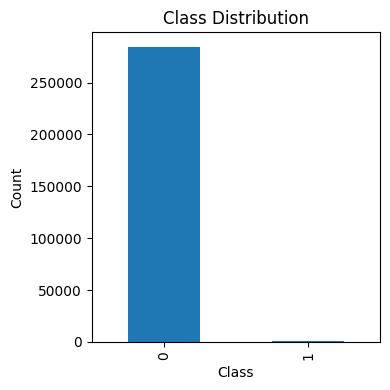

In [14]:
plt.figure(figsize=(4, 4))
df["Class"].value_counts().plot(kind="bar")
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


### Preprocessing and Feature Engineering


In [15]:
df["Amount_log"] = np.log1p(df["Amount"])
df["transaction_hour"] = ((df["Time"] % (60 * 60 * 24)) // 3600).astype(int)

df = df.dropna(subset=["Class"])
df["Class"] = df["Class"].astype(int)

feature_cols = ["Time", "Amount", "Amount_log", "transaction_hour"] + [f"V{i}" for i in range(1, 29)]
target_col = "Class"
X = df[feature_cols]
y = df[target_col]
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=SEED)
val_size = 0.15 / 0.85
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size, stratify=y_train_val, random_state=SEED)
numeric_to_scale = ["Time", "Amount", "Amount_log", "transaction_hour"]
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_to_scale)
    ],
    remainder="passthrough"
)
X_train_smote, y_train_smote = SMOTE(random_state=SEED).fit_resample(X_train, y_train)
scale_pos_weight = float((y_train == 0).sum() / (y_train == 1).sum())


### Supervised Modeling: XGBoost Baseline


In [16]:
xgb_clf = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="aucpr",
    tree_method="hist",
    random_state=SEED,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight
)
supervised_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", xgb_clf)
    ]
)
supervised_pipeline.fit(
    X_train_smote,
    y_train_smote,
)


/usr/local/lib/python3.12/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Time', 'Amount',
                                                   'Amount_log',
                                                   'transaction_hour'])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=None,
                               enable_categor...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=500, n_jobs=-1,
                               num_parallel_tree=None, ...))])

### Evaluation: Supervised Model


              precision    recall  f1-score   support

           0     0.9998    0.9985    0.9991     42647
           1     0.5039    0.8649    0.6368        74

    accuracy                         0.9983     42721
   macro avg     0.7519    0.9317    0.8180     42721
weighted avg     0.9989    0.9983    0.9985     42721

Val ROC-AUC 0.9690772266862027
Val PR-AUC 0.8621446410038337
Test ROC-AUC 0.9807455880190827
Test PR-AUC 0.8362680172821009


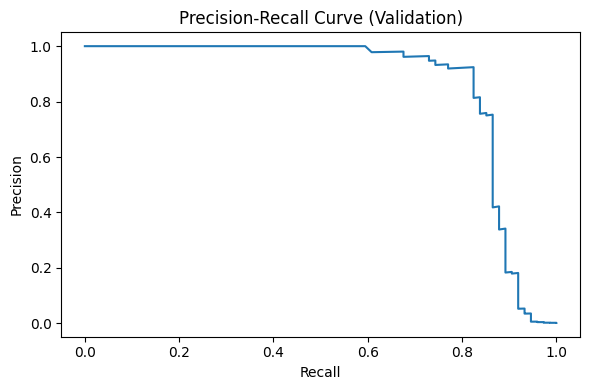

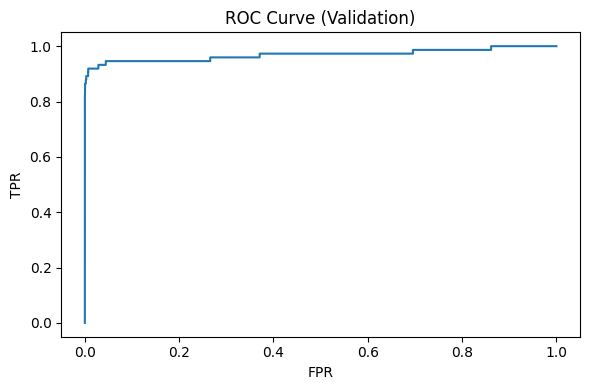

array([[42584,    63],
       [   10,    64]])

In [17]:
y_val_pred_proba = supervised_pipeline.predict_proba(X_val)[:, 1]
y_test_pred_proba = supervised_pipeline.predict_proba(X_test)[:, 1]
y_val_pred = (y_val_pred_proba >= 0.5).astype(int)
y_test_pred = (y_test_pred_proba >= 0.5).astype(int)
print(classification_report(y_val, y_val_pred, digits=4))
print("Val ROC-AUC", roc_auc_score(y_val, y_val_pred_proba))
print("Val PR-AUC", average_precision_score(y_val, y_val_pred_proba))
print("Test ROC-AUC", roc_auc_score(y_test, y_test_pred_proba))
print("Test PR-AUC", average_precision_score(y_test, y_test_pred_proba))
precision, recall, pr_thresholds = precision_recall_curve(y_val, y_val_pred_proba)
fpr, tpr, roc_thresholds = roc_curve(y_val, y_val_pred_proba)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Validation)")
plt.tight_layout()
plt.show()
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve (Validation)")
plt.tight_layout()
plt.show()
cm = confusion_matrix(y_val, y_val_pred)
cm


### Anomaly Detection Models: IsolationForest and Autoencoder


In [18]:
X_train_nonfraud = X_train[y_train == 0]
preprocessor_fitted = supervised_pipeline.named_steps["preprocess"]
X_train_nonfraud_trans = preprocessor_fitted.transform(X_train_nonfraud)
X_val_trans = preprocessor_fitted.transform(X_val)
X_test_trans = preprocessor_fitted.transform(X_test)
iso_forest = IsolationForest(
    n_estimators=200,
    max_samples="auto",
    contamination=0.001,
    random_state=SEED,
    n_jobs=-1
)
iso_forest.fit(X_train_nonfraud_trans)
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
input_dim = X_train_nonfraud_trans.shape[1]
autoencoder = Autoencoder(input_dim).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
criterion = nn.MSELoss()
train_dataset = TensorDataset(torch.tensor(X_train_nonfraud_trans, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
epochs = 20
for epoch in range(epochs):
    autoencoder.train()
    epoch_loss = 0.0
    for batch in train_loader:
        batch_x = batch[0].to(device)
        optimizer.zero_grad()
        recon = autoencoder(batch_x)
        loss = criterion(recon, batch_x)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_x.size(0)
    epoch_loss = epoch_loss / len(train_dataset)


### Ensemble Risk Scoring and Threshold Selection


In [19]:
def autoencoder_errors(model, data_array):
    model.eval()
    with torch.no_grad():
        x_tensor = torch.tensor(data_array, dtype=torch.float32).to(device)
        recon = model(x_tensor)
        errors = torch.mean((recon - x_tensor) ** 2, dim=1).cpu().numpy()
    return errors
iso_val_raw = -iso_forest.score_samples(X_val_trans)
iso_test_raw = -iso_forest.score_samples(X_test_trans)
ae_val_errors = autoencoder_errors(autoencoder, X_val_trans)
ae_test_errors = autoencoder_errors(autoencoder, X_test_trans)
iso_min = float(iso_val_raw.min())
iso_max = float(iso_val_raw.max())
ae_max = float(ae_val_errors.max())
iso_val_norm = (iso_val_raw - iso_min) / (iso_max - iso_min + 1e-8)
iso_test_norm = (iso_test_raw - iso_min) / (iso_max - iso_min + 1e-8)
ae_val_norm = ae_val_errors / (ae_max + 1e-8)
ae_test_norm = ae_test_errors / (ae_max + 1e-8)
w_supervised = 0.7
w_iso = 0.15
w_autoencoder = 0.15
risk_val = w_supervised * y_val_pred_proba + w_iso * iso_val_norm + w_autoencoder * ae_val_norm
risk_test = w_supervised * y_test_pred_proba + w_iso * iso_test_norm + w_autoencoder * ae_test_norm
nonfraud_mask = y_val == 0
threshold = float(np.quantile(risk_val[nonfraud_mask], 0.99))
y_val_risk_pred = (risk_val >= threshold).astype(int)
y_test_risk_pred = (risk_test >= threshold).astype(int)
print("Ensemble Validation Classification Report")
print(classification_report(y_val, y_val_risk_pred, digits=4))
print("Ensemble Validation ROC-AUC", roc_auc_score(y_val, risk_val))
print("Ensemble Validation PR-AUC", average_precision_score(y_val, risk_val))
print("Ensemble Test ROC-AUC", roc_auc_score(y_test, risk_test))
print("Ensemble Test PR-AUC", average_precision_score(y_test, risk_test))


Ensemble Validation Classification Report
              precision    recall  f1-score   support

           0     0.9998    0.9900    0.9949     42647
           1     0.1356    0.9054    0.2359        74

    accuracy                         0.9898     42721
   macro avg     0.5677    0.9477    0.6154     42721
weighted avg     0.9983    0.9898    0.9936     42721

Ensemble Validation ROC-AUC 0.9810328536147469
Ensemble Validation PR-AUC 0.8099023255613016
Ensemble Test ROC-AUC 0.9551374672365106
Ensemble Test PR-AUC 0.7996637767441376


### Model Export and SHAP Setup


In [21]:
background = X_train.sample(n=min(200, len(X_train)), random_state=SEED)
joblib.dump(background, models_dir / "shap_background.joblib")

xgb_model = supervised_pipeline.named_steps["model"]
preprocess = supervised_pipeline.named_steps["preprocess"]

background_trans = preprocess.transform(background)
explainer = shap.TreeExplainer(xgb_model)

sample = X_val.iloc[[0]]
sample_trans = preprocess.transform(sample)
shap_values = explainer(sample_trans)
shap_values.values.shape

(1, 32)

### Inference Demo


In [22]:
sample_tx = X_test.iloc[[0]]
prob = supervised_pipeline.predict_proba(sample_tx)[:, 1][0]
sample_tx_trans = preprocessor_fitted.transform(sample_tx)
iso_score_raw = -iso_forest.score_samples(sample_tx_trans)[0]
iso_norm = (iso_score_raw - iso_min) / (iso_max - iso_min + 1e-8)
ae_error = autoencoder_errors(autoencoder, sample_tx_trans)[0]
ae_norm = ae_error / (ae_max + 1e-8)
risk = w_supervised * prob + w_iso * iso_norm + w_autoencoder * ae_norm
label = int(risk >= threshold)

xgb_model = supervised_pipeline.named_steps["model"]
preprocess = supervised_pipeline.named_steps["preprocess"]
sample_tx_trans_for_shap = preprocess.transform(sample_tx)
explainer_demo = shap.TreeExplainer(xgb_model)
shap_vals_demo = explainer_demo(sample_tx_trans_for_shap)

vals = shap_vals_demo.values[0]
abs_vals = np.abs(vals)
top_idx = np.argsort(abs_vals)[-3:][::-1]
top_features = []
for idx in top_idx:
    top_features.append({
        "feature": feature_cols[idx],
        "value": float(sample_tx.iloc[0, idx]),
        "contribution": float(vals[idx])
    })
prob, risk, label, top_features

(np.float32(7.779918e-08),
 np.float64(0.024618697999664655),
 0,
 [{'feature': 'V12',
   'value': 0.783574381949087,
   'contribution': -5.178918838500977},
  {'feature': 'V14',
   'value': 0.197456169863999,
   'contribution': -5.08830451965332},
  {'feature': 'V8',
   'value': 0.690354533062417,
   'contribution': -3.1012423038482666}])

In [23]:
from google.colab import files
!zip -r models.zip models
files.download('models.zip')


  adding: models/ (stored 0%)
  adding: models/preprocessor.joblib (deflated 55%)
  adding: models/supervised_pipeline.joblib (deflated 70%)
  adding: models/config.json (deflated 51%)
  adding: models/iso_forest.joblib (deflated 74%)
  adding: models/shap_background.joblib (deflated 11%)
  adding: models/autoencoder.pt (deflated 14%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>